## RAG NO ESTRUCTURADO PARTE 1

In [1]:
from dotenv import load_dotenv
import os


load_dotenv()


openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    raise ValueError("No se encontró OPENAI_API_KEY en las variables de entorno")

llama_cloud_api= os.getenv('LLAMA_CLOUD_API_KEY')
if not llama_cloud_api:
    raise ValueError("No se encontró LLAMA_CLOUD_API_KEY en las variables de entorno")

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

llm = ChatOpenAI(
    model='gpt-4.1-nano',
    api_key=openai_api_key
)

model_embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    openai_api_key=openai_api_key
)

## La primera parte, determinar el documento y extraer la información del mismo

In [2]:
from langchain_community.document_loaders import PyPDFLoader

file_path_ej = 'nuevo_testamento.pdf'
loader_ej = PyPDFLoader(file_path_ej)
documents_ej = loader_ej.load()
print(f"Loaded {len(documents_ej)} pages from {file_path_ej}")

Loaded 499 pages from nuevo_testamento.pdf


## Esto es lo que haría alguien normal. Pero aquí no somos normales😈

In [3]:
###from langchain_unstructured import UnstructuredLoader
##from langchain.document_loaders import UnstructuredPDFLoader
##
##loader =  UnstructuredLoader(
##    file_path=file_path,
##    strategy="hi_res",
##    partition_via_api=False,
##)
#docs = []
#for doc in loader.lazy_load():
#    docs.append(doc)

from llama_parse import LlamaParse
# from llama_cloud_services import LlamaParse

import nest_asyncio
nest_asyncio.apply()

parser = LlamaParse(
    api_key=llama_cloud_api,  
    #num_workers=4, 
    mode='auto',
    verbose=True,
    language="es",  
    result_type="markdown"
)

file_path='nuevo_testamento.pdf'

docs=parser.load_data(file_path)

print(f"Loaded {len(docs)} pages from {file_path}")

Started parsing the file under job_id b7f5e94b-882a-48f5-a09a-f0fe737b015b
.......Loaded 499 pages from nuevo_testamento.pdf


## REDONDO!!, ya extraímos un pdf semánticamente con todo..... Ahora hagamos un chunking inteligente

In [5]:
from chunking_evaluation.utils import openai_token_count
from chromadb.utils import embedding_functions

embedding_function = embedding_functions.OpenAIEmbeddingFunction(
    api_key=openai_api_key,
    model_name='text-embedding-3-small',
)

from chunking_evaluation.chunking import ClusterSemanticChunker

chunker = ClusterSemanticChunker(
    embedding_function=embedding_function,
    max_chunk_size=400,  ## Mientras mas grande es el chunk size se favorece al contexto y mientras mas pequeño es se favorece la busqueda granular
    min_chunk_size=200,  
    length_function=openai_token_count, 
)

split_chunks = []
for doc in docs:
    
    doc_chunks = chunker.split_text(doc.get_content())
    split_chunks.extend([
        {
            "text": chunk,
            "metadata": {
                "source": "nuevo_testamento.pdf",
                "page": doc.metadata.get("page", "unknown") if doc.metadata else "unknown"
            }
        }
        for chunk in doc_chunks
    ])

print(f"Lo partimos en.... {len(split_chunks)} chunks")


c:\Users\Abraham Pérez\OneDrive\Desktop\Trabajo\panomada\repositorio_canal\agent_edu\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Abraham Pérez\OneDrive\Desktop\Trabajo\panomada\repositorio_canal\agent_edu\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Lo partimos en.... 1500 chunks


## Genial!! ya tenemos un split semántico hecho a medida, ahora vayamos al corazón de esto, la indexación.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, HnswConfigDiff, PointStruct
import uuid

qdrant_client = QdrantClient(url="http://localhost:6333")

vectors_config = VectorParams(
    size=1536,
    distance=Distance.COSINE,  # Aquí se suele escoger entre coseno o eucladiana, en casos de rag lo recomendable es coseno
    hnsw_config=HnswConfigDiff(
        m=25, # Cantidad de conexiones en el grafo HNSW en cada iteración
        ef_construct=200, # Cantidad de conexiones en el grafo HNSW al momento de construir el índice
        full_scan_threshold=10000, # Cantidad de puntos a partir de la cual se hace un escaneo completo en vez de usar el índice HNSW
        payload_m=25, # Cantidad de conexiones en el grafo HNSW para los payloads (recomendable mismo que m)
    )
)

collection_name = 'Biblia'
qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=vectors_config,
)

def process_and_upload_batches(chunks, batch_size=500):
    batch_texts, batch_metas, batch_ids = [], [], []

    for i, chunk in enumerate(chunks):
        batch_texts.append(chunk["text"])
        batch_metas.append(chunk["metadata"])
        batch_ids.append(str(uuid.uuid4()))

        # Cuando alcanzamos el batch o es el último chunk:
        if len(batch_texts) == batch_size or i == len(chunks) - 1:
            print(f"Procesando batch de {len(batch_texts)} chunks…")
            batch_vectors = model_embeddings.embed_documents(batch_texts)

            qdrant_client.upsert(
                collection_name=collection_name,
                points=[
                    PointStruct(
                        id=_id,
                        vector=vec,
                        payload={"text": txt, **meta}
                    )
                    for _id, vec, txt, meta in zip(batch_ids, batch_vectors, batch_texts, batch_metas)
                ]
            )
            batch_texts, batch_metas, batch_ids = [], [], []

    print("✅ Subida completa.")

process_and_upload_batches(split_chunks, batch_size=500)  ## Gestionamos la subida en batches para evitar problemas de memoria optimizando así los recursos y asegurandonos que la carga sea eficiente


# —————————————————————————
# 3. Verificación
# —————————————————————————

info = qdrant_client.get_collection(collection_name)
print(f"Número total de puntos: {info.points_count}")

test_embedding = model_embeddings.embed_query("Hebreos capítulo 9")
results = qdrant_client.search(
    collection_name=collection_name,
    query_vector=test_embedding,
    limit=1
)
if results:
    pt = results[0]
    print(f"Texto: {pt.payload.get('text')} — Score: {pt.score}")
else:
    print("❌ No se encontraron resultados.")

Procesando batch de 500 chunks…
Procesando batch de 500 chunks…
Procesando batch de 500 chunks…
Procesando batch de 500 chunks…
Procesando batch de 500 chunks…
✅ Subida completa.
Número total de puntos: 1500
✅ Subida completa.
Número total de puntos: 1500
Texto: # HEBREOS 8:11–9:8

Pondré mis leyes en la mente de ellos, y sobre su corazón las escribiré; y yo seré su Dios, y ellos serán mi pueblo.

Y ninguno enseñará a su prójimo, ni ninguno a su hermano, diciendo: Conoce al Señor, porque todos me conocerán, desde el menor hasta el mayor de ellos.

Porque seré misericordioso en cuanto a sus maldades, y de sus pecados y de sus iniquidades no me acordaré más.

Cuando dice: Nuevo convenio, ha dado por viejo al primero; y lo que se da por viejo y se envejece, cerca está de desaparecer.

# CAPÍTULO 9 — Score: 0.6016425
Texto: # HEBREOS 8:11–9:8

Pondré mis leyes en la mente de ellos, y sobre su corazón las escribiré; y yo seré su Dios, y ellos serán mi pueblo.

Y ninguno enseñará a su prójim

C:\Users\Abraham Pérez\AppData\Local\Temp\ipykernel_8768\1238361107.py:63: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant_client.search(


## Ya con la base de datos creada y definida con hnsw, podemos definirla como metodo de recuperación 📊📈

In [ ]:
from qdrant_client import QdrantClient
collection_name = 'Biblia'

qdrant_client= QdrantClient(url="http://localhost:6333")

from langchain_qdrant import QdrantVectorStore
from langchain_qdrant.qdrant import RetrievalMode

os.environ["OPENAI_API_KEY"] = openai_api_key  


vectorstore = QdrantVectorStore(
    client=qdrant_client, 
    collection_name=collection_name, 
    embedding=model_embeddings,
    retrieval_mode= RetrievalMode.DENSE,
    content_payload_key="text",
)

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold",   # ajusta el tipo de busqueda segun sea tu caso, clasica, mmr o similarity_score_threshold
    search_kwargs={
        "k": 7,
        "score_threshold": 0.5,
        #"filter": None,
        #"hnsw_ef": 200,
        #"fetch_k":20,
        #"lambda_mult": 0.5,
        
    }
)

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_biblia",
    "Busca y retorna toda la información disponible de la Biblia, con este medio puedes tomar y buscar absolutamente toda la información de la Biblia",
)

tools = [retriever_tool]

## Con esto definimos nuestra vectorstore como recuperación!! con esto usaremos activamente nuestro algoritmo ann, ahora hagamos el agente que recuperará esta vectorstore

In [8]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Definimos el estado inicial del agente, ahora el pipeline, el cual es el agentic rag que ya vimos en videos anteriores

In [9]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges




def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("---CHECK RELEVANCE---")
    print("\n=== DOCUMENTOS RECUPERADOS DE QDRANT ===")
    messages = state["messages"]
    last_message = messages[-1]
    
    # Extraemos los documentos del mensaje del retriever
    if hasattr(last_message, 'tool_responses') and last_message.tool_responses:
        docs = last_message.tool_responses[0]
    else:
        docs = last_message.content
    
    # Añadimos logging detallado de los documentos recuperados
    if docs and isinstance(docs, str) and len(docs.strip()) > 0:
        print("\nDocumentos encontrados:")
        print("-" * 50)
        print(f"Contenido: {docs}")
        print("-" * 50)
        has_content = True
    else:
        print("\n⚠️ No se recuperaron documentos de Qdrant")
        has_content = False
    
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatOpenAI(temperature=0, model="gpt-4.1-mini", streaming=True)

    llm_with_tool = model.with_structured_output(grade)

    # Si no hay contenido, retornamos directamente a rewrite
    if not has_content:
        print("\n❌ DECISION: DOCS NOT RELEVANT - No content")
        return "rewrite"
    
    # Prompt
    prompt = PromptTemplate(
        template="""YOU ARE AN EXPERT RELEVANCE EVALUATOR TASKED WITH DETERMINING WHETHER A RETRIEVED DOCUMENT PROVIDES CONTENT THAT IS MEANINGFULLY RELATED TO A USER'S QUESTION. YOU MUST CONDUCT A COMPREHENSIVE, DEEP ANALYSIS OF THE ENTIRE DOCUMENT — NOT JUST PARTIAL OR SUPERFICIAL SEGMENTS — TO ASSESS ITS RELEVANCE BASED ON BOTH EXPLICIT AND IMPLICIT CONNECTIONS TO THE QUESTION.

###INSTRUCTIONS###

- YOU MUST READ THE ENTIRE DOCUMENT CONTEXT THOROUGHLY, WITHOUT SKIPPING OR SUMMARIZING PREMATURELY
- IDENTIFY NOT ONLY DIRECT KEYWORDS BUT ALSO SEMANTICALLY RELATED CONCEPTS, IMPLICATIONS, OR SUPPORTING INFORMATION
- EVALUATE WHETHER THE DOCUMENT OFFERS INFORMATION THAT IS **DIRECTLY**, **INDIRECTLY**, OR **CONTEXTUALLY** HELPFUL IN ADDRESSING THE USER QUESTION
- RETURN A **BINARY JUDGMENT**: `'yes'` IF THE DOCUMENT IS RELEVANT IN ANY SUBSTANTIVE WAY, `'no'` IF IT IS NOT

###CHAIN OF THOUGHTS TO FOLLOW###

1. UNDERSTAND: COMPREHEND THE FULL USER QUESTION — INCLUDING INTENT, SCOPE, AND IMPLIED INFORMATION NEEDS  
2. BASICS: IDENTIFY FUNDAMENTAL TERMS, ENTITIES, AND CONCEPTS IN THE QUESTION  
3. BREAK DOWN: PARSE THE DOCUMENT INTO MEANINGFUL UNITS (PARAGRAPHS, ARGUMENTS, DATA POINTS)  
4. ANALYZE: FOR EACH UNIT, ASSESS WHETHER IT CONTRIBUTES TO ANSWERING OR EXPLORING THE USER QUESTION  
5. BUILD: AGGREGATE INSIGHTS FROM THE DOCUMENT TO FORM AN OVERALL RELEVANCE JUDGMENT  
6. EDGE CASES: IF THE DOCUMENT PROVIDES ONLY BACKGROUND, INDIRECT INSIGHT, OR SUPPORTING DATA — IT **STILL COUNTS AS RELEVANT**  
7. FINAL ANSWER: OUTPUT `'yes'` IF THE DOCUMENT IS RELEVANT IN ANY WAY TO THE QUESTION, OTHERWISE `'no'`

###INPUT###

- RETRIEVED DOCUMENT:  
```
{context}
```

- USER QUESTION:  
```
{question}
```

###OUTPUT FORMAT###

Return only:
`yes` — if the document meaningfully contributes to answering or informing the question  
`no` — if it is wholly unrelated in substance

###WHAT NOT TO DO###

- DO NOT JUDGE BASED ON KEYWORDS ALONE — SEMANTIC MEANING AND CONTEXT MATTER  
- DO NOT IGNORE PARTS OF THE DOCUMENT — FULL CONTEXT MUST BE CONSIDERED  
- DO NOT DEFAULT TO `'no'` IF THE RELEVANCE IS INDIRECT — INFERENTIAL LINKS AND BACKGROUND STILL COUNT  
- DO NOT PROVIDE EXPLANATIONS — ONLY RETURN `'yes'` OR `'no'`  
- DO NOT GUESS BASED ON TOPIC SIMILARITY WITHOUT SUBSTANTIVE OVERLAP""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    question = messages[0].content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("\n✅ DECISION: DOCS RELEVANT")
        return "generate"

    else:
        print("\n❌ DECISION: DOCS NOT RELEVANT")
        print(f"Score: {score}")
        return "rewrite"




### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4.1-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]


    model = ChatOpenAI(temperature=0, model="gpt-4.1-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer based on retrieved documents
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    
    # Extraemos los documentos del mensaje del retriever
    if hasattr(last_message, 'tool_responses') and last_message.tool_responses:
        docs = last_message.tool_responses[0]
    else:
        docs = last_message.content
        
    # Debug log para ver qué documentos estamos usando
    print("\n=== DOCUMENTOS USADOS PARA GENERAR RESPUESTA ===")
    print("-" * 50)
    print(f"Documentos: {docs}")
    print("-" * 50)

    prompt = hub.pull("rlm/rag-prompt")
    llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

## Ya con la logica inicial hecha, definimos nuestro grafo

In [10]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode


workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)  
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  
workflow.add_node("rewrite", rewrite)  
workflow.add_node(
    "generate", generate
)  
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()

## Visualizamos como implementamos tecnicas de agentic en el retrieve

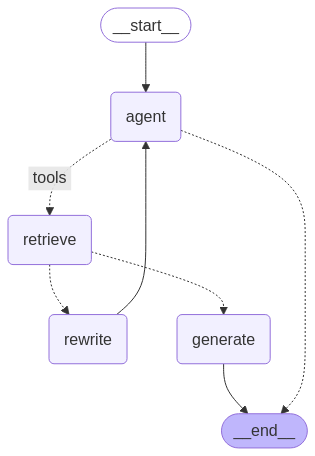

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

## A disfrutar

In [21]:
import pprint

inputs = {
    "messages": [
        ("user", "En el libro de los romanos en que capitulo se habla de la paciencia?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DLrTaYRvYo40bIOTdWRYjiji', 'function': {'arguments': '{"query":"paciencia en el libro de los romanos"}', 'name': 'retrieve_biblia'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_79b79be41f'}, id='run-53a6ec4f-f735-408d-8d68-cb12cd3bcc97-0', tool_calls=[{'name': 'retrieve_biblia', 'args': {'query': 'paciencia en el libro de los romanos'}, 'id': 'call_DLrTaYRvYo40bIOTdWRYjiji', 'type': 'tool_call'}])]}
'\n---\n'
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DLrTaYRvYo40bIOTdWRYjiji', 'function': {'arguments': '{"query":"paciencia en el libro de los romanos"}', 'name': 'retrieve_biblia'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model

c:\Users\Abraham Pérez\OneDrive\Desktop\Trabajo\panomada\repositorio_canal\agent_edu\Lib\site-packages\langsmith\client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'En el libro de Romanos, la paciencia se menciona '
                'especialmente en el capítulo 15, versículos 4 y 5, donde se '
                'habla de la paciencia y consolación de las Escrituras para '
                'tener esperanza, y se menciona a Dios como el Dios de la '
                'paciencia y consolación. También se alude a la paciencia en '
                'Romanos 12:12, donde se exhorta a ser sufridos en la '
                'tribulación.']}
'\n---\n'


 Ya que le delegamos el trabajo de creación de la pregunta al nodo del agente  las preguntas de recuperación están optimizadas para tener solo el contexto relevante y poder obtener la mejor info (de ejemplo la ejecución anterior) donde se ve que de la pregunta

- En que libro se narra la conversion de saulo?

Se genera la query
- {"query":"paciencia en el libro de los romanos"}'

De igual manera recopilando la información de los otros documentos y versículos es capaz de determinar el contexto y situación de este capitulo en cuestión lo cual habla positivamente del rag.


Para  que veas como sería con la pregunta exacta aquí se muestra un pequeño ejemplo



In [24]:
test_embedding = model_embeddings.embed_query("Que dice san pablo a los hebreos en el capitulo 1?")
results = qdrant_client.search(
    collection_name=collection_name,
    query_vector=test_embedding,
    limit=8,
)
if results:
    pt = results[0]
    print(f"Texto: {pt.payload.get('text')} — Score: {pt.score}")
else:
    print("❌ No se encontraron resultados.")

Texto: 22 Y asimismo, prepárame también alojamiento, porque espero que por vuestras oraciones yo os sea concedido.

23 Te saludan a Epafras, mi compañero de prisión por Cristo Jesús,

24 Marcos, Aristarco, a Demas y Lucas, mis colaboradores.

25 La gracia de nuestro Señor Jesucristo sea con vuestro espíritu. Amén.

Fue enviada a Filemón desde Roma por medio de Onésimo, esclavo.

# EPÍSTOLA DEL APÓSTOL SAN PABLO A LOS HEBREOS

# CAPÍTULO 1

DIOS, habiendo hablado muchas veces y de muchas maneras en otro tiempo a los padres por medio de los profetas,

2 en estos postreros días nos ha hablado por el Hijo, a quien 16 a GEE Hermano(s), 2 Tim. 4:10. 1 1 a GR en muchos lugares y de varias maneras.

22 a 2 Cor. 1:11; [HEBREOS] b GEE Profeta.

23 a Col. 4:12. Título: GEE Hebreos, epístola a los; Pablo;

24 a Col. 4:14; Pablo, epístolas de. — Score: 0.65185577


C:\Users\Abraham Pérez\AppData\Local\Temp\ipykernel_8768\2137503557.py:2: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant_client.search(


## Esto es una sola forma de miles que hay, podemos hacer reranking, multiquery.... Ya eso es contenido para otro video🧮🧮

## Para ver la explicación completa de este codigo y más visita mi canal de [Youtube](https://www.youtube.com/@AbrahamP%C3%A9rezIA), Gracias por leer hasta el final y espero que te sea de mucha ayuda :D